In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")

## Loading Dataset

In [58]:
data = pd.read_csv("china_gdp.csv")
data = data[["Year","Value2","Value1"]]

In [59]:
test = data.iloc[55,:]
data.drop(55,axis=0,inplace=True)

In [60]:
data = np.array(data)

## Shuffling Datapoints

In [61]:
indes = np.arange(0,len(data))
random.shuffle(indes)

In [62]:
data = data[indes]

## Train Test Split

In [63]:
x_train,y_train = data[:55,:-1], data[:55,-1]
x_test,y_test = test[:-1],test[-1]

In [64]:
y_train = np.reshape(y_train,(y_train.shape[0],1))

## Standardising the Data

In [65]:
x_test[0] = (x_test[0]-x_train[:,0].mean())/x_train[:,0].std()
x_train[:,0] = (x_train[:,0]-x_train[:,0].mean())/np.std(x_train[:,0])
y_train = (y_train-y_train.mean())/y_train.std()

## AdaSainiBoosting from Scratch
#### Note: There is no such algorithm by this name. I gave it mine for fun.

In [113]:
class AdaSainiBoost:
    def __init__(self,learning_rate=0.01,init_val=0.1):
        self.learning_rate = learning_rate
        self.init_val = init_val
        self.mse_curve = []
    def fit(self,x_train,y_train,estimators=100,iterer=10000):
        ins_weights = np.array([[1/len(x_train)] for _ in range(len(x_train))])
        for i in range(estimators):
            x_train = ins_weights * x_train
            weights = np.random.uniform(-self.init_val,self.init_val,size=(x_train.shape[1],1))
            bias = np.random.uniform(-self.init_val,self.init_val,size=1)
            for _ in range(iterer):
                preds = np.dot(x_train,weights)+bias
                loss = preds-y_train
                loss_std = loss/len(x_train)
                weights = weights - self.learning_rate*np.dot(x_train.T,loss_std)
                bias = bias - self.learning_rate*np.sum(loss_std)
            self.mse_curve.append(((preds-y_train)**2).mean())
            adj_error = np.array([1 if abs(i)>=np.absolute(loss).mean() else 0 for i in loss])
            et = sum(ins_weights[:,0]*adj_error)
            self.imp = et/(1-et)
            ins_weights = np.array([ins_weights[i]*(self.imp**(1-adj_error[i])) for i in range(len(ins_weights))])
            ins_weights /= sum(ins_weights)
        self.coef_ = weights
        self.intercept_ = bias
    def predict(self,x_test):
        self.preds = np.dot(x_test,self.coef_)+self.intercept_
        return self.preds

In [114]:
l = AdaSainiBoost(learning_rate=0.0001)

In [115]:
l.fit(x_train,y_train,iterer=100,estimators=100)

In [116]:
l.predict(x_test)

array([-0.11377878])

## Epoch vs MSE Curve

In [117]:
mse = l.mse_curve

In [118]:
mse = [mse[i] for i in range(1,101,10)]

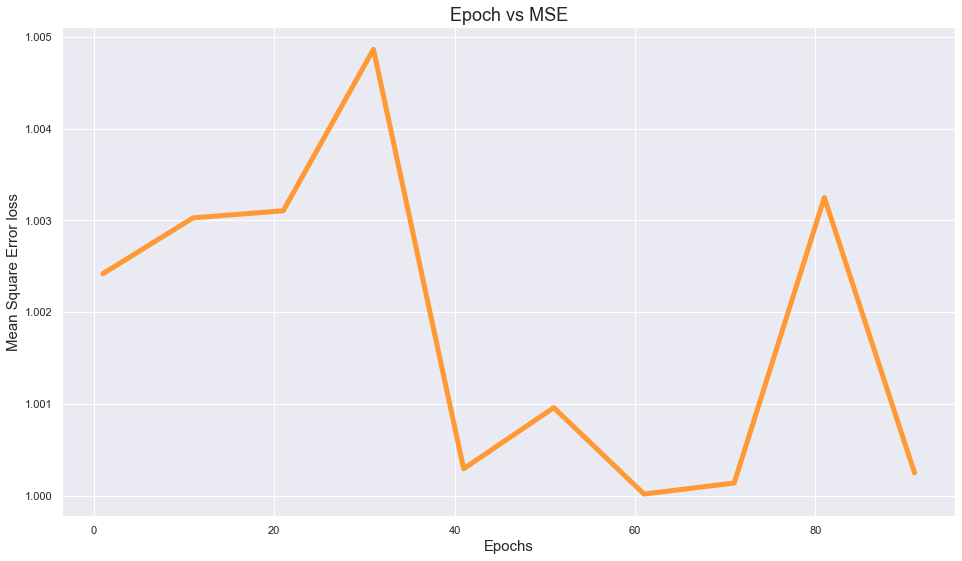

In [122]:
plt.figure(figsize=(16,9))
sns.lineplot(np.arange(1,101,10),mse,color="#ff9933",linewidth=5)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Mean Square Error loss",fontsize=15)
plt.title("Epoch vs MSE",fontsize=18)
plt.show()

## Feature Importance

In [123]:
"""
The importance of a feature can be determined by the variance it have. The more the variance the more
importance it holds in calculating the dependant variable. So here I am going to use variance as a 
factor to determine feature importance.
"""

'\nThe importance of a feature can be determined by the variance it have. The more the variance the more\nimportance it holds in calculating the dependant variable. So here I am going to use variance as a \nfactor to determine feature importance.\n'

In [129]:
for i,j in enumerate(["Year","Value2"]):
    print(f"{j}: Variance = {round(x_train[:,i].var(),3)}; Standard Deviation = {round(x_train[:,i].std(),3)}")

Year: Variance = 1.0; Standard Deviation = 1.0
Value2: Variance = 0.0; Standard Deviation = 0.0


In [ ]:
"""
Here we can see that while Year have a St. Deviation of 1, Value2 hold no St. Deviation. This is 
because of the fact that Value2 have no values other than 2. Hence we can safely remove Value2 from
the model and no significant change would be observed.
"""